# Scaffold analysis

We have already dealt extensively with chemical substructures in [exercise 5](../exercises/5_substructures_and_filters.ipynb). There, we have defined the observed substructures explicitly (MACCS and other structural keys) or implicitly (ECFP, other fingerprints). In this exercise, we will try to reduce chemical structures to their main structural motif, i.e. a central characteristic "framework" of the structure.

These "core" structural motifs, often called "scaffolds", are usually obtained by getting rid of all specifics about atoms (atom element, valence, charge, etc.) and bonds (bond type, bond order, etc.), chopping off all sidechains and keeping only the rings and the linkers between them. Some scaffolding methodologies will even contract linkers, normalize ring sizes, consecutively remove rings, etc. The role of scaffolds is to look upon chemical structures in a more abstract fashion, and to group them together based on shared central motifs.

Very popular scaffold type are what we call "Murcko scaffolds", obtained by normalizing all atoms and bonds of the processed structure, followed by sidechain removal. Some scaffolding methods are [implemented in RDKit](https://www.rdkit.org/docs/source/rdkit.Chem.Scaffolds.html), including the Murcko scaffolds we will use in this exercise.

Plenty of useful information about scaffolds can be viewed in the [OG article](https://sci-hub.tw/https://pubs.acs.org/doi/10.1021/jm9602928)

So, let's start scaffolding :)

# What to do:
 - Familiarize yourself with the concept of structural scaffolds. You probably already know it from the lecture materials, but just to be sure :)
 - Perform a scaffold analysis of the DrugBank database. Have a look at the most common scaffolds amongst drugs.
 - Perform a scaffold analysis of your ligand set. What are the most prevalent scaffolds/central structural motifs in your ligand set? 
 - Compare the scaffold composition of your ligand set and DrugBank. What are the differences? Are the scaffolds of your ligand set somewhat common amongst known drugs, or is it something more exotic?
 - Perform a scaffold-based diversity picking from your ligand set. Represent each scaffold in your ligand set by a single chemical structure.

In [2]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import csv

RDKit WARNING: [21:58:29] Enabling RDKit 2019.09.3 jupyter extensions


This time, we will load the [pChEMBL value](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3965067/) alongside our ligands. It is a standardized value of activity assigned by ChEMBL based the actual measured values (EC50, IC50, Ki, etc.) Its use is simpler than the raw measurements, even though it lacks direct interpretation and is basically "the more pChEMBL, the more adidas". It is however very useful for rough ordering and comparison, i.e. what we will be doing here. If you prefer other measurements, load any activity type you desire.

In [27]:
# load your own set, and DrugBank :)
with open('DRD1.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    drd1_ligands = []
    for m in reader:
        if m['Smiles'] != '':
            mol = Chem.MolFromSmiles(m['Smiles'])
        # get the standardized pChEMBL activity measure for future use
        pchembl = m['pChEMBL Value']
        if not pchembl:
            # some don't have any comparable pChEMBL value, just assign them very low value
            pchembl = -1
        mol.SetDoubleProp('pChEMBL', float(pchembl)) # save the value into mol instance
        drd1_ligands.append(mol)

suppl = Chem.SDMolSupplier('../data/drugbank.sdf')
drugs = [m for m in suppl if m]

Let's have a look at the first ligand in our set:

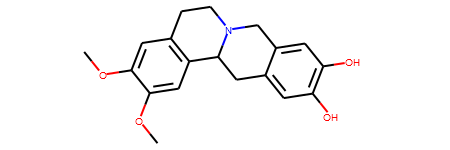

In [37]:
drd1_ligands[0]

Nothing new here. Let's try to get its scaffold:

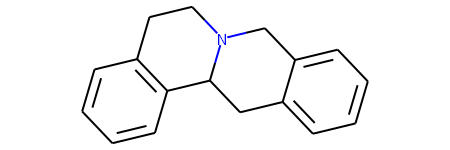

In [38]:
from rdkit.Chem.Scaffolds import MurckoScaffold
scaffold1 = MurckoScaffold.GetScaffoldForMol(drd1_ligands[0])
scaffold1

This has removed the sidechains, but all the heteroatoms still remain. Let's normalize all atoms into carbon, all bonds into single:

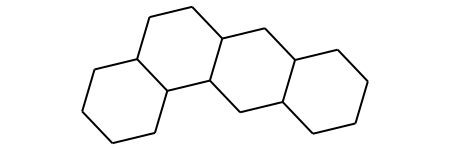

In [39]:
scaffold2 = MurckoScaffold.MakeScaffoldGeneric(scaffold1)
scaffold2

Now we are getting a much rougher outline. Let's get rid of the newfound sidechains by running it through RDKit scaffolding again:

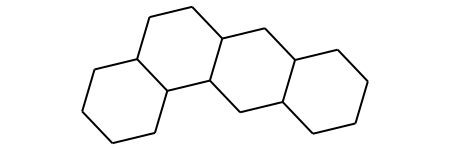

In [40]:
scaffold3 = MurckoScaffold.GetScaffoldForMol(scaffold2)
scaffold3

... which gives us the barebone Murcko scaffold of our first ligand. All heteroatoms, bonds, sidechains are abstracted away. Looks like a pretty bare core of a Markush structure. For more convenience, let's implement the scaffolding process as a function:

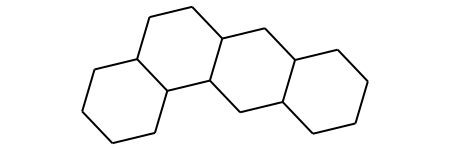

In [41]:
def scaffold(mol):
    Chem.rdmolops.RemoveStereochemistry(mol) # get rid of stereo, doesn't matter much in scaffolds
    try:
        scaff = MurckoScaffold.MakeScaffoldGeneric(mol) # all atoms->C all bonds-> single
    except ValueError: # if the structure can't be represented by C atoms, just return no scaffold.
        # if such functionality is really desired, then generic graphs can be used instead of C
        return None
    scaff = MurckoScaffold.GetScaffoldForMol(scaff) # remove all sidechains
    return scaff
scaffold(drd1_ligands[0])

The function seems to work fine, we can go ahead. Let's scaffold all drugs in DrugBank:

In [42]:
drugbank_scaffolds = [scaffold(drug) for drug in drugs]
drugbank_scaffolds[:20]

 None,

Of course, the generated scaffolds are all RDKit Mol instances. For easy comparison, let's turn them into SMILES strings. Identical scaffolds = identical scaffold SMILES = identical text strings. Comparing instances directly would be much less convenient.

In [43]:
drugbank_scaffolds_smiles = [(i, Chem.MolToSmiles(mol)) for i, mol in enumerate(drugbank_scaffolds) if mol]
drugbank_scaffolds_smiles[:20]

[(0,
  'C(CCCCCCCCCCCC(CCCCCCCCCCC1CCCC1CCCCCCCCCCC1CCCCC1)CC1CCCCC1)CCCCCCCCCCCC1CCCC1CCCCC1CCCC1CCCC1CCCCC1'),
 (1,
  'C(CCCCCC(CCCCCC(CCC(CCC1CCCC1)CC1CCCC1)CC1CCC2CCCCC21)CC1CCCCC1)CCCCC1CCCC1'),
 (2, 'C1CCCCC(CC2CCCCC2)CCC(CC2CCCCC2)CCCCCCCC(CC2CCCC2)CCC1'),
 (3,
  'C(CCCCCC(CCCCCC(CCC(CCCCC1CCC2CCCCC2C1)CC1CCCCC1)CC1CCCCC1)CC1CCCCC1)CCCCC1CCCC1'),
 (4, 'C1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC1'),
 (5, 'C1CCCCC(CC2CCCCC2)CCC(CC2CCCCC2)CCCCCCCC(CC2CCCC2)CCC1'),
 (6, 'C1CCCCCCC(CCCCC2CCCCC2)CCC(CC2CCCCC2)CCC(CC2CCC3CCCCC32)CCCCCC1'),
 (7, 'C1CCCCC1'),
 (9, 'C1CCC(CCC2CCC3CCCCC3C2)CC1'),
 (10, 'C1CCCC1'),
 (11, 'C1CCC2C(C1)CCC2C1CCCC1'),
 (12, ''),
 (13, 'C1CCCCC1'),
 (14, 'C1CC2CCCC2C1'),
 (15, ''),
 (16, ''),
 (17, ''),
 (18, 'C1CCCC1'),
 (19, ''),
 (20, '')]

Apparently some structures have no scaffolds (or, in other terms, have zero-atom scaffolds). Let's have a look at structure with index 12, the first with such a non-scaffold:

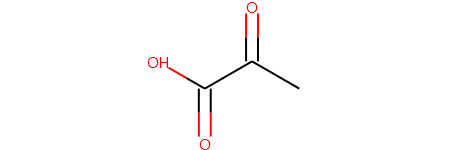

In [44]:
drugs[12]

Well, the scaffold function cuts all sidechains and leaves only rings and their linkers. No ring means an empty scaffold for this scaffold implementation.

Also, the structure with index 8 was not scaffolded at all. Let's have a look at it:

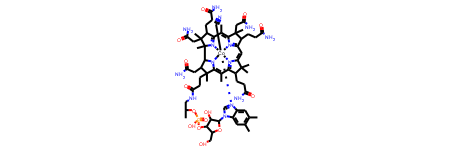

In [45]:
drugs[8]

... yeah, just carbons do not quite do it here, the hexavalent cobalt messes the scaffold up. Let's continue with the vast majority of structures that can be transformed into their C-based generic structural motif, and group them by their scaffolds:

In [46]:
scaffolds2drugs = {scaffoldsmiles:[] for drug_idx, scaffoldsmiles in drugbank_scaffolds_smiles}
for drug_idx, scaffoldsmiles in drugbank_scaffolds_smiles:
    scaffolds2drugs[scaffoldsmiles].append(drug_idx)
scaffolds2drugs

{'C(CCCCCCCCCCCC(CCCCCCCCCCC1CCCC1CCCCCCCCCCC1CCCCC1)CC1CCCCC1)CCCCCCCCCCCC1CCCC1CCCCC1CCCC1CCCC1CCCCC1': [0,
  2059],
 'C(CCCCCC(CCCCCC(CCC(CCC1CCCC1)CC1CCCC1)CC1CCC2CCCCC21)CC1CCCCC1)CCCCC1CCCC1': [1,
  529],
 'C1CCCCC(CC2CCCCC2)CCC(CC2CCCCC2)CCCCCCCC(CC2CCCC2)CCC1': [2, 5, 2324],
 'C(CCCCCC(CCCCCC(CCC(CCCCC1CCC2CCCCC2C1)CC1CCCCC1)CC1CCCCC1)CC1CCCCC1)CCCCC1CCCC1': [3,
  4676],
 'C1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC1': [4],
 'C1CCCCCCC(CCCCC2CCCCC2)CCC(CC2CCCCC2)CCC(CC2CCC3CCCCC32)CCCCCC1': [6],
 'C1CCCCC1': [7,
  13,
  27,
  39,
  54,
  56,
  59,
  67,
  72,
  73,
  78,
  81,
  82,
  89,
  102,
  108,
  112,
  123,
  126,
  127,
  131,
  134,
  149,
  154,
  155,
  161,
  171,
  181,
  192,
  196,
  198,
  202,
  206,
  224,
  228,
  234,
  257,
  258,
  268,
  276,
  285,
  305,
  306,
  310,
  315,
  318,
  333,
  336,
  346,
  350,
  361,
  370,
  375,
  376,
  378,
  381,
  386,
  408,
  416,
  429,
  430,
  435,
  443,
  459,
  477,
  479,
  484,
  494,
  495,
  497,
  512,
  514,

Above, we have a dictionary with scaffold SMILES, mapping to IDs of the drugs which contain them. We can count the IDs assigned to each scaffold to get an idea which scaffolds are most frequent amongst drugs:

In [47]:
scaffold_drugcount = [(scaffold, len(drugs)) for scaffold, drugs in scaffolds2drugs.items()]
len(scaffold_drugcount), scaffold_drugcount[:20]

(1545,
 [('C(CCCCCCCCCCCC(CCCCCCCCCCC1CCCC1CCCCCCCCCCC1CCCCC1)CC1CCCCC1)CCCCCCCCCCCC1CCCC1CCCCC1CCCC1CCCC1CCCCC1',
   2),
  ('C(CCCCCC(CCCCCC(CCC(CCC1CCCC1)CC1CCCC1)CC1CCC2CCCCC21)CC1CCCCC1)CCCCC1CCCC1',
   2),
  ('C1CCCCC(CC2CCCCC2)CCC(CC2CCCCC2)CCCCCCCC(CC2CCCC2)CCC1', 3),
  ('C(CCCCCC(CCCCCC(CCC(CCCCC1CCC2CCCCC2C1)CC1CCCCC1)CC1CCCCC1)CC1CCCCC1)CCCCC1CCCC1',
   2),
  ('C1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC1', 1),
  ('C1CCCCCCC(CCCCC2CCCCC2)CCC(CC2CCCCC2)CCC(CC2CCC3CCCCC32)CCCCCC1', 1),
  ('C1CCCCC1', 1039),
  ('C1CCC(CCC2CCC3CCCCC3C2)CC1', 54),
  ('C1CCCC1', 188),
  ('C1CCC2C(C1)CCC2C1CCCC1', 165),
  ('', 976),
  ('C1CC2CCCC2C1', 15),
  ('C1CCC(CCC2CCCC3CCCC32)CC1', 28),
  ('C(CCCCCCCCCC1CCCCC1)CCCCCCCCC1CCCCC1', 2),
  ('C1CCC2CC3CCCCC3CC2C1', 57),
  ('C1CCC2CCCC2C1', 192),
  ('C1CCC(CC2CCCC2)CC1', 74),
  ('C(CCCC1CCC(C2CCCCC2)C1)CCCC1CCC(C2CCC3CCCCC32)C1', 17),
  ('C1CCC2CCCCC2C1', 169),
  ('C1CCC(C2CCCCC2C2CCCC2)CC1', 1)])

In [48]:
scaffold_drugcount.sort(key=lambda x: x[1], reverse=True)
scaffold_drugcount[:20]

[('C1CCCCC1', 1039),
 ('', 976),
 ('C1CCC2CCCC2C1', 192),
 ('C1CCCC1', 188),
 ('C1CCC(CC2CCCCC2)CC1', 182),
 ('C1CCC(C2CCCC2)CC1', 176),
 ('C1CCC2CCCCC2C1', 169),
 ('C1CCC2C(C1)CCC2C1CCCC1', 165),
 ('C1CCC2C(C1)CCC1C3CCCC3CCC21', 151),
 ('C1CCC(CCC2CCCCC2)CC1', 106),
 ('C1CCC(C2CCCCC2)CC1', 105),
 ('C1CCC(CC2CCCC2)CC1', 74),
 ('C1CCC(CCCC2CCCCC2)CC1', 66),
 ('C1CCC2CC3CCCCC3CC2C1', 57),
 ('C1CCC(CCC2CCC3CCCCC3C2)CC1', 54),
 ('C1CCC(CCCCC2CCCCC2)CC1', 53),
 ('C1CCC(C2CC3CCCCC3C2)CC1', 48),
 ('C1CCC(CCC2CCCC2)CC1', 43),
 ('C1CCC(C2CCC3CCCCC3C2)CC1', 41),
 ('C1CCC(CC2CCCC(CC3CCCCC3)C2)CC1', 34)]

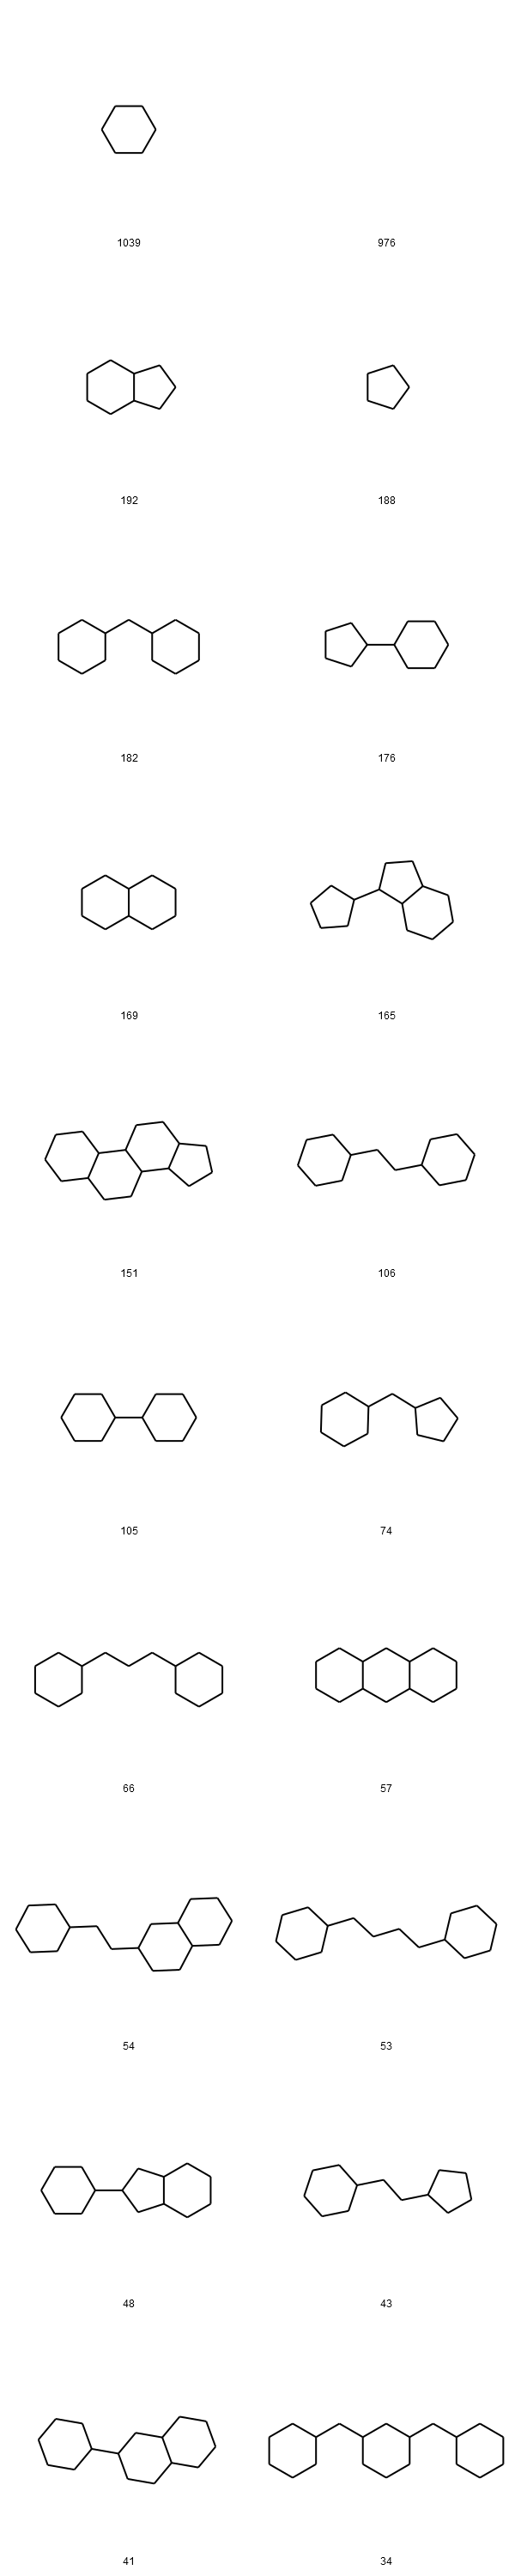

In [49]:
Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold, count in scaffold_drugcount[:20]],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=[str(count) for scaffold, count in scaffold_drugcount[:20]])

Above, we have the most common Murcko scaffolds within DrugBank. Apparently, many substances in DrubBank are just some six-membered ring with sidechains, and almost as many are completely acyclical. This means a lot of DrugBank molecules are quite simple and small. Following those two motifs, we have sturctures based on five-membered rings and a lot of some quite standard-looking arrangements of two rings. The most frequent 3-ringed motif seems to be that of Ademetionine and [similar structures](https://www.drugbank.ca/structures/search/small_molecule_drugs/structure?database_id=DB00118&search_type=similarity#results), with a wide variety of uses. Right next to it is an already very large 4-ringed motif, and I am sure you can recognize the steroid core even at this level of simplification ;). Other frequent scaffolds seem more or less par for course, two- or three-ringed arrangements.

Let's do the same scaffold analysis for our ligand set, and have a look if/how they differ from the usual DrugBank stuff :)

In [50]:
drd1_scaffolds_smiles = [(i, Chem.MolToSmiles(scaffold(ligand))) for i, ligand in enumerate(drd1_ligands)]
drd1_scaffolds_smiles[:20]

[(0, 'C1CCC2CC3C(CCC4CCCCC43)CC2C1'),
 (1, 'C1CCC(C2CCC(CCCC3CCC(CCCCC4CCC5CCCCC5C(C5CCCCC5)C4)C3)CC2)CC1'),
 (2, 'C1CCCC1'),
 (3, 'C1CCCC1'),
 (4, 'C1CCC(CCCCC2CCCCC2)CC1'),
 (5, 'C1CCC2CC3CCCCC3CC2C1'),
 (6, 'C1CCC(CC2CCCCC2)CC1'),
 (7, 'C1CCCCCC2CCCCC2C2CCC(CCCC1)C2'),
 (8, 'C1CCCCC1'),
 (9, 'C1CC2CCC1CC1CCC(CC1)CC1CCC(CC1)CC1CCC(CC1)CC1CCC(CC1)CC1CCC(CC1)C2'),
 (10, 'C1CC2CCC3C(CCC4CC5CCCC5C43)C2C1'),
 (11, ''),
 (12, 'C1CCCCC1'),
 (13, 'C1CCC(CC2CCCC2)CC1'),
 (14, 'C1CC2CC3CCCC45C3CCC(CCC3CCC6C7CCCC68C3CC3CCCC(C7)C38)C4CC(C1)C25'),
 (15, 'C1CCC(C2C3CCCCC3CCC3CCCC32)CC1'),
 (16, 'C1CCC(CC2CCCC2)CC1'),
 (17, 'C1CCC(CC2CCCC2)CC1'),
 (18, 'C1CCC(CC2CCC3CC4CCCCC4C3C2)C1'),
 (19, 'C1CCC(C2CCCC3CCCCC32)CC1')]

In [51]:
scaffolds2ligands = {scaffoldsmiles:[] for ligand_idx, scaffoldsmiles in drd1_scaffolds_smiles}
for ligand_idx, scaffoldsmiles in drd1_scaffolds_smiles:
    scaffolds2ligands[scaffoldsmiles].append(ligand_idx)
scaffolds2ligands

{'C1CCC2CC3C(CCC4CCCCC43)CC2C1': [0,
  20,
  25,
  128,
  140,
  167,
  183,
  199,
  244,
  245,
  314,
  366,
  381,
  409,
  410,
  411,
  437,
  453,
  502,
  514,
  569,
  651,
  653,
  654,
  663,
  733,
  742,
  756,
  860,
  942,
  946,
  947,
  948,
  975,
  989,
  996,
  1029,
  1032,
  1034,
  1052,
  1053,
  1062,
  1073],
 'C1CCC(C2CCC(CCCC3CCC(CCCCC4CCC5CCCCC5C(C5CCCCC5)C4)C3)CC2)CC1': [1],
 'C1CCCC1': [2,
  3,
  48,
  202,
  216,
  269,
  342,
  344,
  444,
  489,
  578,
  619,
  655,
  711,
  718,
  737,
  837,
  838,
  930,
  1020,
  1036,
  1043],
 'C1CCC(CCCCC2CCCCC2)CC1': [4, 197, 308, 348, 455, 1018],
 'C1CCC2CC3CCCCC3CC2C1': [5, 114, 400, 473, 474, 795, 889, 936, 1001, 1046],
 'C1CCC(CC2CCCCC2)CC1': [6,
  66,
  98,
  115,
  149,
  192,
  200,
  260,
  301,
  349,
  367,
  388,
  407,
  416,
  421,
  494,
  598,
  603,
  639,
  709,
  712,
  755,
  829,
  851,
  907,
  928,
  931],
 'C1CCCCCC2CCCCC2C2CCC(CCCC1)C2': [7],
 'C1CCCCC1': [8,
  12,
  33,
  35,
  36,
  42

In [52]:
scaffold_ligandcount = [(scaffold, len(ligands)) for scaffold, ligands in scaffolds2ligands.items()]
scaffold_ligandcount.sort(key=lambda x: x[1], reverse=True)
len(scaffold_ligandcount), scaffold_ligandcount

(332,
 [('C1CCCCC1', 131),
  ('', 54),
  ('C1CCC2C(C1)CCC1C3CCCC3CCC21', 44),
  ('C1CCC2CC3C(CCC4CCCCC43)CC2C1', 43),
  ('C1CCC2CCCCC2C1', 32),
  ('C1CCC(C2CCCCC3CCCCC32)CC1', 30),
  ('C1CCC2C(C1)CC1CCCC3CCCC2C31', 28),
  ('C1CCC(CC2CCCCC2)CC1', 27),
  ('C1CCC(CCC2CCCCC2)CC1', 25),
  ('C1CCC(C2CCCCC2)CC1', 25),
  ('C1CCC2CCCC2C1', 24),
  ('C1CCCC1', 22),
  ('C1CCC(C2CCCC2)CC1', 18),
  ('C1CCC(CCC2CCCC2)CC1', 17),
  ('C1CCC2CC3C(CCC4CC5CCCC5CC43)CC2C1', 16),
  ('C1CCC(CC2CCCC2)CC1', 11),
  ('C1CCC2CC3CCCCC3CC2C1', 10),
  ('C1CCC(CCCC2CCCC2)CC1', 10),
  ('C1CCC(C2CCC3CCCCC3C2)CC1', 9),
  ('C1CCC2CC3CCCCC3CCC2C1', 8),
  ('C1CCC(C2CCC3CCCCC32)CC1', 8),
  ('C1CCC(CCCC2CCCCC2)CC1', 8),
  ('C1CCC2C(C1)CCC1C2CCC2C3CCCC3CC21', 7),
  ('C1CCC(C2CC3CCCCC3C2)CC1', 7),
  ('C1CCC(CC2CCC3CCCCC32)CC1', 7),
  ('C1CCC(CCCCC2CCCCC2)CC1', 6),
  ('C1CCC(CC2CCC3CCCC3C2)CC1', 6),
  ('C1CCC(CC2CCC(CC3CCCCC3)CC2)CC1', 6),
  ('C1CCC(C2CCCC2C2CCCCC2)CC1', 6),
  ('C1CCC2C(C1)CC1CCC3CCCC2C31', 6),
  ('C1CCC(CCC2CCC

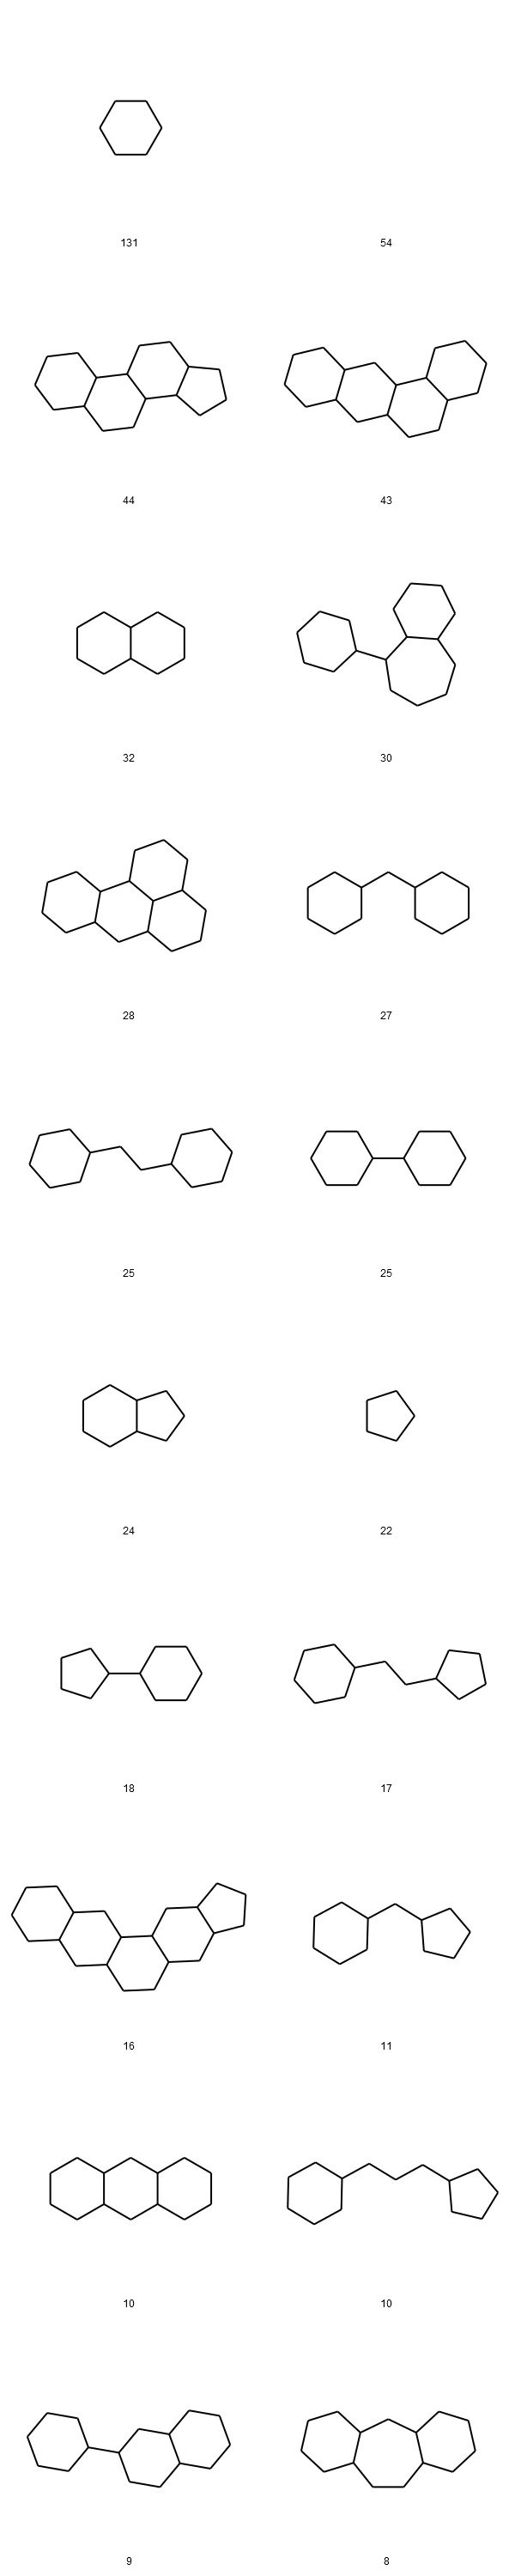

In [53]:
Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold, count in scaffold_ligandcount[:20]],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=[str(count) for scaffold, count in scaffold_ligandcount[:20]])

The scaffolds common amongst the analyzed drd1 ligands seem to be similar to the ones common in DrugBank, there are however even tetra- or pentacyclic structures with cojoined rings (e.g. 16).

From this very coarse view, the chemical variety of this particular drd1 ligand set seems quite broad - a good thing, there seems to be a variety of chemotypes to work with. In case of having extreme large scaffolds their potential as drugs for peroral administration could be negatively impacted, as discussed in our previous exercise on [drug likeness](../exercises/4_drug_likeness.ipynb).

## Scaffold-based diversity picking

In the [previous exercise](8_structural_similarity.ipynb), we ended with some diversity picking to select a small, yet still representative subset of our full set of ligands. There, we used their mutual (dis)similarity. Another approach for picking a representative subset is, as you have probably already guessed, by scaffolds. This is done quite often for the purposes of [chemical space exploration](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3998053/), but can be just as easily used to present chemists with some actual structures that back up the more abstract scaffold analysis.

This type of diversity picking is quite straightforward in concept, it just means representing each scaffold by a single structure (often the most potent one), or some sort of [stratified sampling](https://en.wikipedia.org/wiki/Stratified_sampling) from various scaffolds.

Let's try the simplest approach, and represent each scaffold in our ligand set by its most active (by pChEMBL value) ligand:

In [54]:
scaffold_representatives = {}
for scaffold, ligands in scaffolds2ligands.items():
    scaffold_representatives[scaffold] = sorted(ligands,
                                                key=lambda x: mtor_ligands[x].GetProp('pChEMBL'),
                                                reverse=True)[0]
len(scaffold_representatives), scaffold_representatives

(332,
 {'C1CCC2CC3C(CCC4CCCCC43)CC2C1': 569,
  'C1CCC(C2CCC(CCCC3CCC(CCCCC4CCC5CCCCC5C(C5CCCCC5)C4)C3)CC2)CC1': 1,
  'C1CCCC1': 2,
  'C1CCC(CCCCC2CCCCC2)CC1': 4,
  'C1CCC2CC3CCCCC3CC2C1': 5,
  'C1CCC(CC2CCCCC2)CC1': 6,
  'C1CCCCCC2CCCCC2C2CCC(CCCC1)C2': 7,
  'C1CCCCC1': 626,
  'C1CC2CCC1CC1CCC(CC1)CC1CCC(CC1)CC1CCC(CC1)CC1CCC(CC1)CC1CCC(CC1)C2': 9,
  'C1CC2CCC3C(CCC4CC5CCCC5C43)C2C1': 10,
  '': 877,
  'C1CCC(CC2CCCC2)CC1': 13,
  'C1CC2CC3CCCC45C3CCC(CCC3CCC6C7CCCC68C3CC3CCCC(C7)C38)C4CC(C1)C25': 14,
  'C1CCC(C2C3CCCCC3CCC3CCCC32)CC1': 15,
  'C1CCC(CC2CCC3CC4CCCCC4C3C2)C1': 18,
  'C1CCC(C2CCCC3CCCCC32)CC1': 19,
  'C1CCC(CCCC2CCC(C3CCCC4C3CC(C3CCCCC3)C4C3CCCCC3)CC2)CC1': 21,
  'C1CCC(C2CCC(CCC(C3CCCCC3)C3CCCCC3)CC2)CC1': 22,
  'C1CCC(CCCCC2CCC(CCCCC3CCCCC3)CC2)CC1': 23,
  'C1CCC(CCC2CCCCC2)CC1': 532,
  'C1CCC2C(C1)CCC1C3CCCC3CCC21': 27,
  'C1CCC(CC2CCC3CCCC3C2)CC1': 28,
  'C1CCC(C2CCCC2)CC1': 29,
  'C1CCC2CCCC2C1': 30,
  'C1CCC(C(C2CCCCC2)C2CCCCC2)CC1': 75,
  'C1CCC(C2CCC3CCCC4CCCC2C43)C

In [55]:
# prep for our amazing visualization of scaffolds and representative structures side by side :)
scaffold_representatives4visualization = []
for scaffold, ligandcount in scaffold_ligandcount:
    mol = Chem.MolFromSmiles(scaffold)
    mol.SetProp('legend', str(ligandcount) + " ligands")
    scaffold_representatives4visualization.append(mol)
    representative_mol = mtor_ligands[scaffold_representatives[scaffold]]
    representative_mol.SetProp('legend', "#{} | pChEMBL {}".format(str(scaffold_representatives[scaffold]),
                                                            representative_mol.GetProp('pChEMBL')))
    scaffold_representatives4visualization.append(representative_mol)
len(scaffold_representatives4visualization), scaffold_representatives4visualization[:20]

(664,
  <rdkit.Chem.rdchem.Mol at 0x1cf236f69e0>])

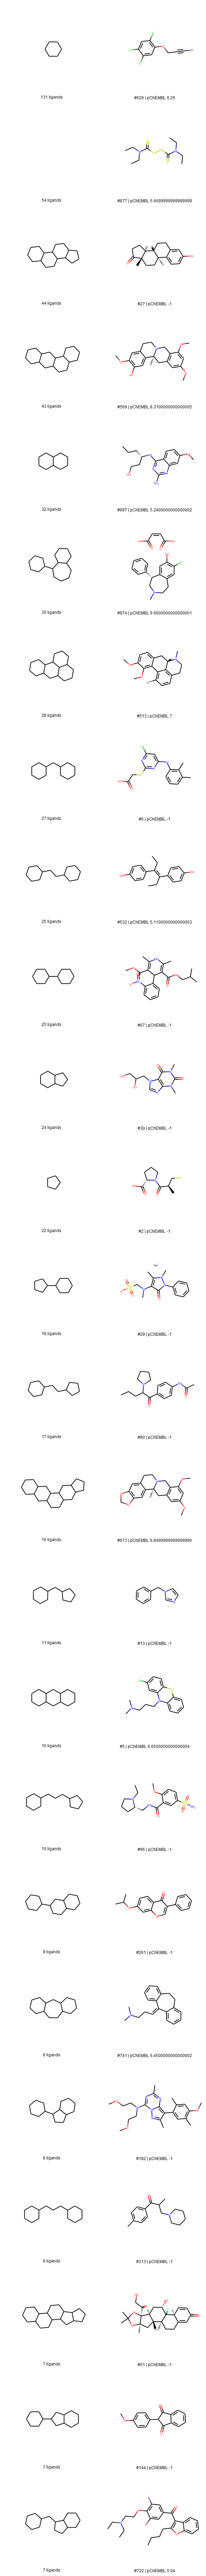

In [56]:
Draw.MolsToGridImage(scaffold_representatives4visualization[:50],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=[mol.GetProp('legend')
                              for mol in scaffold_representatives4visualization[:50]])

And here is our simple scaffold-based picking. For each scaffold (on the left, from the most prevalent ones to the least), the most active mtor ligand was selected (on the right). This puts side-by-side the general frequent chemotype, and a sample from the actual ligands it represents.